In [158]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Ridge, LinearRegression,Lasso
from sklearn.metrics import mean_squared_error
from ipywidgets import interact, FloatSlider
from numpy.random import seed, randn
from sklearn.model_selection import cross_validate, train_test_split,GridSearchCV, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_regression
from sklearn.feature_selection import RFE
import seaborn as sbn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [2]:
import pandas as pd
#Importar los datos
housing = pd.read_csv("./Documents/Diplomado ds & ml/house-prices/train.csv")
housing=housing.drop("Id", axis=1)
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Analisis de la variable objetivo

In [3]:
housing[["SalePrice"]].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


Con esto podemos pensar que la variable objetivo se mide en decenas de miles

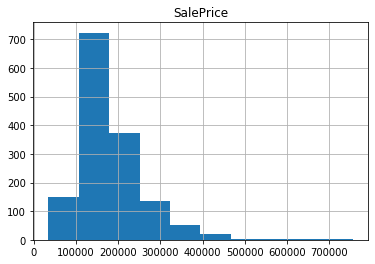

In [4]:
housing[["SalePrice"]].hist();

Podemos observar la consentracion de 1 a 2.5 unidades, es decir de 10,000 a 25,000

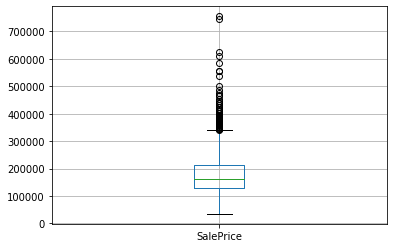

In [5]:
housing[["SalePrice"]].boxplot();

Analisis de variables predictoras.

Separo en dos grupos para darles un tratamiento distinto a las variables categoricas y a las numericas.

In [6]:
categorical=housing.select_dtypes(include='object')
categorical.shape

(1460, 43)

In [7]:
numeric=housing.select_dtypes(include=['float64','int64'])

numeric=numeric.drop("SalePrice", axis=1)
columnas=numeric.columns
numeric.shape

(1460, 36)

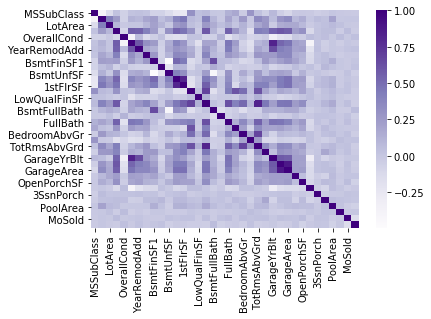

In [8]:
sbn.heatmap(numeric.corr(method ='pearson') ,cmap='Purples');

Para las variables numericas me quedare con el top 12 determinado por el metodo de recursive feature elimination,
buscando mejorar la version pasada que solo consideraba a quellas con corr mas alta.

In [13]:
housing.corr().SalePrice.abs().sort_values().tail(13)

BsmtFinSF2       0.011378
BsmtHalfBath     0.016844
MiscVal          0.021190
LowQualFinSF     0.025606
YrSold           0.028923
3SsnPorch        0.044584
MoSold           0.046432
OverallCond      0.077856
MSSubClass       0.084284
PoolArea         0.092404
ScreenPorch      0.111447
EnclosedPorch    0.128578
KitchenAbvGr     0.135907
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePrice, dtype: float64

Voy a imputar datos para hacer Recursive Feature Elimination

In [9]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(numeric)
numeric=imp_mean.transform(numeric)
numeric.shape

(1460, 36)

Conservo el modelo ridge pues es el que tengo como referencia de la version anterior y me gustaria mejorarlo sobre esa base

In [10]:
# feature extraction
model =  Ridge()
rfe = RFE(model, 12)
fit = rfe.fit(numeric,housing.SalePrice)

#print("Num Features: %d" % fit.n_features_)
#print("Selected Features: %s" % fit.support_)
#print("Feature Ranking: %s" % fit.ranking_)
print("Las columnas seleccionadas son : %s" % columnas[fit.support_])

Selected Columns: Index(['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'YrSold'],
      dtype='object')


Como referencia en la tarea 1 las variables que mas aportaban eran:

"YearRemodAdd",
 "YearBuilt",     
 "TotRmsAbvGrd",     
 "FullBath",        
 "1stFlrSF",      
 "TotalBsmtSF",     
 "GarageArea",      
 "GarageCars",      
 "GrLivArea",        
 "OverallQual",      
 "GarageYrBlt",
 "MasVnrArea",

Para las variables categoricas conservamos las que mejoran algo al agregarse al modelo, probando una a una

In [12]:
cate= [ "Utilities","MSZoning" ,      
         "Street"   ,        
         "Alley"      ,      
         "LotShape"    ,     
         "LandContour"  ,    
         "Utilities"     ,   
         "LotConfig"      ,  
         "LandSlope"       , 
         "Neighborhood"  ,   
         "Condition1"      , 
         "Condition2"     ,  
         "BldgType"        , 
         "HouseStyle"       ,
         "RoofStyle"        ,
         "RoofMatl"         ,
         "Exterior1st"      ,
         "Exterior2nd"      ,
         "MasVnrType"       ,
         "ExterQual"        ,
         "ExterCond"        ,
         "Foundation"       ,
         "BsmtQual"         ,
         "BsmtCond"         ,
         "BsmtExposure"     ,
         "BsmtFinType1"     ,
         "BsmtFinType2"     ,
         "Heating"          ,
         "HeatingQC"        ,
         "CentralAir"       ,
         "Electrical"       ,
         "KitchenQual"      ,
         "Functional"       ,
         "FireplaceQu"      ,
         "GarageType"       ,
         "GarageFinish"     ,
         "GarageQual"       ,
         "GarageCond"       ,
         "PavedDrive"       ,
         "PoolQC"           ,
         "Fence"            ,
         "MiscFeature"      ,
         "SaleType"         
                 ]

housing.loc[:,cate]=housing[cate].fillna("default")

#reviso una a una las variables categoricas y guardo en una lista las que crean una mejora
mejora=[]
for x in cate:
    column_selector = ColumnTransformer(
        [("label_bin", OneHotEncoder(handle_unknown="ignore",sparse=False), ["MSZoning", "SaleCondition",x]),
         ("numeric", SimpleImputer(), make_column_selector(dtype_include=["float","int","bool"]))]
    )

    pipe = Pipeline([
        ("select_cols", column_selector),
        ("rid", Ridge())
    ])

    train, test = train_test_split(housing, test_size=0.2, random_state=2718)
    xtrain, ytrain = train.drop("SalePrice", axis=1), train["SalePrice"]

    cv = cross_validate(pipe, xtrain, ytrain, cv=5, scoring=["r2", "neg_mean_absolute_error"])
    r2 = cv["test_r2"]
    if r2.mean()>.41 :
        mejora.append(x)
    #mae = -cv["test_neg_mean_absolute_error"]

mejora

['Utilities',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

En resumen nuestras variables seleccionadas son :


In [17]:
categorical[mejora]

,Utilities,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType
0,AllPub,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
1,AllPub,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
2,AllPub,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
3,AllPub,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD
4,AllPub,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,AllPub,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
1456,AllPub,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,TA,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD
1457,AllPub,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,Gd,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD
1458,AllPub,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD


In [18]:
housing[columnas[fit.support_]]

,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,YrSold
0,7,5,1,0,2,1,3,1,8,0,2,2008
1,6,8,0,1,2,0,3,1,6,1,2,2007
2,7,5,1,0,2,1,3,1,6,1,2,2008
3,7,5,1,0,1,0,3,1,7,1,3,2006
4,8,5,1,0,2,1,4,1,9,1,3,2008
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,5,0,0,2,1,3,1,7,1,2,2007
1456,6,6,1,0,2,0,3,1,7,2,2,2010
1457,7,9,0,0,2,0,4,1,9,2,1,2010
1458,5,6,1,0,1,0,2,1,5,0,1,2010


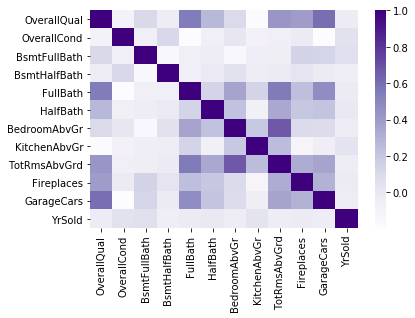

In [19]:
sbn.heatmap(housing[columnas[fit.support_]].corr(method ='pearson') ,cmap='Purples');

Modelo


In [28]:
y=housing[["SalePrice"]]

In [25]:
encoder=OneHotEncoder(handle_unknown="ignore",sparse=False)

In [26]:
X=pd.concat([pd.DataFrame(encoder.fit_transform(housing[mejora]),columns=encoder.get_feature_names()).reset_index(drop=True),housing[columnas[fit.support_]]],axis=1)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Como referencia , las variables seleccionadas obtienen el siguiente desempeno con un modelo Ridge

In [151]:
rid = Ridge()
#svm.fit(X, y.values.reshape(-1,))
cv = cross_validate(svr, X_train,  y_train.values.reshape(-1,), cv=5, scoring=["r2", "neg_mean_absolute_error"])
r2 = cv["test_r2"]

In [152]:
r2.mean()

0.8175055938988166

In [157]:
cv["test_neg_mean_absolute_error"].mean()


-21278.569108872885

Elegi mejorar mi modelo Ridge con AdaBoostRegressor

Explorando

In [136]:
parameters = {'n_estimators':[x*50 for x in range(1,15)], 'loss':("linear", "square", "exponential") ,"learning_rate":[x/100 for x in range(1,8)]}

In [137]:
clf = GridSearchCV(AdaBoostRegressor(Ridge()), parameters,cv=5,n_jobs=-1)

In [138]:
clf.fit(X_train,  y_train.values.reshape(-1,))

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=Ridge(alpha=1.0,
                                                              copy_X=True,
                                                              fit_intercept=True,
                                                              max_iter=None,
                                                              normalize=False,
                                                              random_state=None,
                                                              solver='auto',
                                                              tol=0.001),
                                         learning_rate=1.0, loss='linear',
                                         n_estimators=50, random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                           0.07],
                      

Los paera metros que obtienen la mejor R2 son:

In [141]:
clf.best_params_

{'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 50}

el mejor valor de R2 es 

In [142]:
clf.best_score_

0.820410265065704

este modelo tiene un error absoluto medio de 

In [159]:
mean_absolute_error(y_test,clf.predict(X_test))

22752.408358742567